In [1]:
import os,sys
#If running without a gpu (not recommended) you need to comment out the next two lines.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import Extract_sequences_from_ref as extSeq
import keras
import pandas as pd
import random
import pickle
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, Dropout, Activation
from keras import activations
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib
#matplotlib.use('PS')
import matplotlib.pyplot as plt
import scipy
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
#random.seed(12345)

/Users/jdw297/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#details of run
#fold_num=1
#rep=1
fold_num=sys.argv[1]
rep = sys.argv[2]
out_prefix="pro_term1.5_sb_zm_SC_CO2k_"+"fold"+str(fold_num)+"rep"+str(rep)
wrkdir = "../data/contrast_data/"
#load training and testing sets created by the k-folds ortholog contrast script
train_set=pd.read_csv(wrkdir+"/TMP_TRAIN_SET"+str(fold_num)+".csv")
test_set=pd.read_csv(wrkdir+"/TMP_TEST_SET"+str(fold_num)+".csv")

In [3]:
def join_taxa_and_orthos_SC(taxa, orthos, exclude):
    taxa[0]=taxa[0][taxa[0]['RPK']>exclude]
    taxa[1]=taxa[1][taxa[1]['RPK']>exclude]
    taxa[0].rename(columns={"gene_id":"sorghum","RPK":"sorghum_val"}, inplace=True)
    joint = orthos.merge(taxa[0].copy(),how='left',on="sorghum").copy()
    taxa[1].rename(columns={"gene_id":"maize","RPK":"maize_val"}, inplace=True)
    joint = joint.merge(taxa[1].copy(),how='left',on="maize").copy()
    return joint.copy()

In [4]:
def get_process_trans_data_kkarl():
    zm=pd.read_csv(wrkdir+"/df_STAR_HTSeq_counts_B73_match_based_on_genet_dist_DESeq2_normed_fpm_rounded_origNames_and_Altnames.txt", delimiter=" ")
    zm_GShoot=pd.DataFrame(zm[(zm["TissueWODate"]=="GShoot") & (zm["RNA_TaxaName"]=="B73")].dropna(axis=1).mean(),columns=["RPK"])
    zm_GShoot["gene_id"]=zm_GShoot.index
    zm_GShoot = zm_GShoot.reset_index()[["gene_id","RPK"]]

    sb=pd.read_csv(wrkdir+"/df_STAR_HTSeq_counts_SorghumRootandShoot_DESeq2_normed_fpm_rounded.txt", delimiter=" ")
    sb_GShoot=pd.DataFrame(sb[sb["<Trait>"].isin(["BTx623SbGShoot1","BTx623SbGShoot2"])].mean(), columns=["RPK"])
    sb_GShoot["gene_id"]=pd.DataFrame([x for x in sb_GShoot.index.str.split(".v3.2") if x !=""])[0].values
    sb_GShoot =sb_GShoot.reset_index()[["gene_id","RPK"]]
    taxa=[sb_GShoot,zm_GShoot]
    return taxa

In [5]:
def get_single_copy_sb_zm_pairs():
    pairs=[]
    for line in open(wrkdir+"/zmV3_sbV3_single_copy.txt", "rU"):
        if line[:1]=="#":continue
        zm = line.split("||")[3].split(".v6a")[0].split("_T")[0]
        if "T" in zm:
            zm = zm.replace("T","")
        sb = line.split("||")[11][:-7]
        pairs.append([sb, zm])
    sb_zm_SC = pd.DataFrame(pairs, columns=["sorghum","maize"])
    sb_zm_SC = sb_zm_SC[sb_zm_SC["sorghum"].duplicated(keep=False)==False]
    sb_zm_SC = sb_zm_SC[sb_zm_SC["maize"].duplicated(keep=False)==False]
    return sb_zm_SC

In [6]:
taxa = get_process_trans_data_kkarl()
sb_zm_SC= get_single_copy_sb_zm_pairs()
sb_zm = join_taxa_and_orthos_SC(taxa, sb_zm_SC, exclude=-1)
sb_zm.fillna(0, inplace=True)

In [7]:
print len(sb_zm)
sb_zm.dropna(inplace=True)
print len(sb_zm)

13281
13281


In [8]:
#add small number and log2 transform values
tmp=pd.concat([sb_zm.iloc[:,-2],sb_zm.iloc[:,-2]])
val_to_add=(tmp[tmp!=0].min()/5)
sb_zm["sorghum_val"]=np.log2(sb_zm["sorghum_val"]+val_to_add)
sb_zm["maize_val"]=np.log2(sb_zm["maize_val"]+val_to_add)

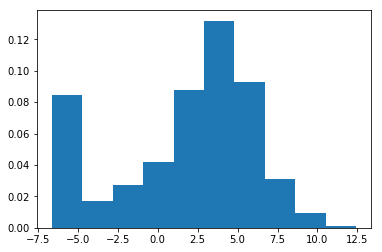

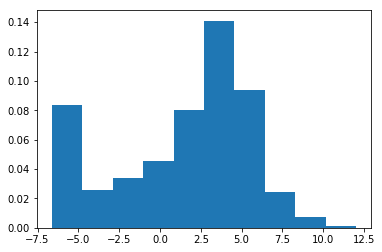

In [9]:
plt.hist(sb_zm["sorghum_val"],normed=True)
plt.show()
plt.hist(sb_zm["maize_val"],normed=True)
plt.show()

In [10]:
sb_zm_pct_rnk = pd.concat([sb_zm.iloc[:,:2],sb_zm.rank(axis=0, pct=True, numeric_only=True)], axis=1)
#red_ortho_pct = OC.rank_TPM_by_subgenome(taxa, red_orthos)

In [11]:
def train_test_ortho_split_w_fams(sb_zm_orth_val, train_set, test_set, val_freq):
    #seperate out test set
    test=sb_zm_orth_val[sb_zm_orth_val["maize"].isin(test_set["gene_id"])]
    train_val=train_set["gene_id"].tolist()
    random.shuffle(train_val)
    #print int(len(train_val)*val_freq)
    val=sb_zm_orth_val[sb_zm_orth_val["maize"].isin(train_val[:int(len(train_val)*val_freq)])]
    train=sb_zm_orth_val[sb_zm_orth_val["maize"].isin(train_val[int(len(train_val)*val_freq):])]
    print train.shape, test.shape, val.shape
    return train, test, val

In [12]:
#split train test val sets based on imported family data
train_orth, test_orth, val_orth = train_test_ortho_split_w_fams(sb_zm_pct_rnk, train_set, test_set, val_freq=0.1)

(8251, 4) (2250, 4) (924, 4)


In [13]:
#sainity check
print [x for x in test_orth.iloc[:,:2].values.flatten() if x in val_orth.iloc[:,:2].values.flatten()]
print [x for x in test_orth.iloc[:,:2].values.flatten() if x in train_orth.iloc[:,:2].values.flatten()]
print [x for x in val_orth.iloc[:,:2].values.flatten() if x in train_orth.iloc[:,:2].values.flatten()]


[]
[]
[]


In [14]:
#process and import sequences and save as pickle if needed

seqs = "both" # promoter, terminator, or both
if "seqs_"+seqs+".p" in os.listdir(wrkdir):
    print "Using existing one-hot files."
    gene_oh1 = pickle.load(open( wrkdir+"/seqs_"+seqs+".p", "rb" ))
else:
    print "processing data... this takes a long time."
    gff3s=["Sbicolor_454_v3.1.1.gene_exons.gff3","Zea_mays.AGPv3.31.gff3"]
    genomes=["Sbicolor_454_v3.0.1.fa","Zea_mays.AGPv3.31.dna.toplevel.fa"]
    genome_paths=[]
    gff3_paths=[]
    for num in range(0,len(gff3s)):
        gff3_paths.append(wrkdir+gff3s[num])
        genome_paths.append(wrkdir+genomes[num])
    #print gff3_paths
    #print genome_paths
    gene_oh1 = extSeq.extract_seqs_from_ref_pro_term_both(genome_paths,gff3_paths,regions=seqs, save_fastq=True, lengths=[1000,500],wrkdir=wrkdir)
    pickle.dump(gene_oh1, open( wrkdir+"/seqs_"+seqs+".p", "wb" ))

processing data... this takes a long time.


In [15]:
def make_pairwise_tensor_sb_zm(gene_oh, joint_orthos, pad, perc_diff_CO, do_flips, bth_directions, balance):
    x_value=[]
    y_value=[]
    droped=[]
    padding=np.zeros((pad,5)).astype('int8')
    pairs_val=[]
    for line in range(0,len(joint_orthos)):
        #print joint_orthos.iloc[line,:]
        ln_list=joint_orthos.iloc[line,:].tolist()
        gene1, gene2 = ln_list[0], ln_list[1]
        val1, val2 = ln_list[2], ln_list[3]
        if gene1 not in gene_oh:continue
        if gene_oh1[gene1][:,4].mean() > 0 :continue
        if gene2 not in gene_oh:continue
        if gene_oh1[gene2][:,4].mean() > 0 :continue
        #print gene1, gene2, val1, val2
        diff = val1-val2
        if abs(diff) < perc_diff_CO: 
            droped.append([gene1,gene2])
            continue
        if diff > 0: up_dwn = 1
        if diff < 0: up_dwn = 0
        #add sequences to x train tensor
        first={"fwd":gene_oh[gene1], "rev":np.flip(gene_oh[gene1], axis=0)}
        second={"fwd":gene_oh[gene2], "rev":np.flip(gene_oh[gene2], axis=0)}
        if do_flips==True:
            flps=["fwd","rev"]
        else:
            flps=["fwd"]
        for rot1 in flps:
            for rot2 in flps:
                pairs_val.append([gene1, gene2, val1, val2, rot1, rot2, diff,up_dwn])
                y_value.append(up_dwn)
                pair_mtx = np.concatenate([first[rot1],padding,second[rot2]])
                x_value.append(pair_mtx)
    x_value=np.array(x_value)
    y_value=np.array(y_value)
    pairs_vals=pd.DataFrame(pairs_val,columns=["gene1", "gene2", "val1", "val2", "rotation1","rotation2"
                                               ,"diff", "up_dwn"])
    print x_value.shape, y_value.shape, len(droped), pairs_vals["up_dwn"].mean()
    if balance=="dwn":   
        x_dummy=[x for x in range(0,len(x_value))]
        x_dummy=np.array(x_dummy).reshape(-1,1)
        rus = RandomUnderSampler(return_indices=True)
        X_resampled, y_resampled, idx_resampled = rus.fit_sample(x_dummy, y_value)
        #print X_resampled.shape, y_resampled.mean()
        x_value=x_value[idx_resampled]
        y_value=y_value[idx_resampled]
        pairs_vals=pairs_vals.loc[idx_resampled].reset_index(drop=True)
        print x_value.shape, y_value.shape, len(droped), pairs_vals["up_dwn"].mean()
    elif balance=="up":
        x_dummy=[x for x in range(0,len(x_value))]
        x_dummy=np.array(x_dummy).reshape(-1,1)
        ros = RandomOverSampler()
        ros = RandomOverSampler()
        X_resampled, y_resampled = ros.fit_sample(x_dummy, y_value)
        #print X_resampled.shape, y_resampled.mean()
        x_value=x_value[X_resampled.flatten()]
        y_value=y_value[X_resampled.flatten()]
        pairs_vals=pairs_vals.loc[X_resampled.flatten()].reset_index(drop=True)
        print x_value.shape, y_value.shape, len(droped), pairs_vals["up_dwn"].mean()
    elif balance=="none": None
    else: print "There are three options for balancing your dataset: 'dwn', 'up', 'none'."
    if bth_directions:
        new_x_value=[]
        new_y_value=[]
        new_pairs_vals=[]
        for row in range(0,len(x_value)):
            first = x_value[row][:(x_value[row].shape[0]-pad)/2]
            second = x_value[row][((x_value[row].shape[0]-pad)/2+pad):]
            #print first.shape,second.shape
            pair_mtx = np.concatenate([second,padding,first])
            new_x_value.append(pair_mtx)
            if y_value[row]==1:
                new_y_value.append(0)
                up_dwn = 0
            if y_value[row]==0:
                new_y_value.append(1)
                up_dwn = 1
            gene1 = pairs_vals.iloc[row,0]
            gene2 = pairs_vals.iloc[row,1]
            val1 = pairs_vals.iloc[row,2]
            val2 = pairs_vals.iloc[row,3]
            rot1 = pairs_vals.iloc[row,4]
            rot2 = pairs_vals.iloc[row,5]
            diff = (pairs_vals.iloc[row,6]*-1)
            new_pairs_vals.append([gene2, gene1, val2, val1, rot2, rot1, diff,up_dwn])
        new_x_value=np.array(new_x_value)
        x_value = np.concatenate((x_value,new_x_value))
        new_y_value=np.array(new_y_value)
        y_value = np.concatenate((y_value,new_y_value))
        new_pairs_vals = pd.DataFrame(new_pairs_vals,columns=["gene1", "gene2", "val1", "val2", "rotation1","rotation2","diff", "up_dwn"])
        pairs_vals = pd.concat([pairs_vals,new_pairs_vals],axis=0).reset_index(drop=True)
        print x_value.shape, y_value.shape, len(droped), pairs_vals["up_dwn"].mean()
    return x_value, y_value, pairs_vals

In [16]:
print out_prefix
pad=30
bal="dwn" #"dwn", "up", "none"
bth_drc=True
rank_change_CO=2000
flps=False
if sb_zm_pct_rnk.sort_values(by=["sorghum_val"]).iloc[-2:,2].diff().values[1] !=0:
    D_rank1=sb_zm_pct_rnk.sort_values(by=["sorghum_val"]).iloc[-2:,2].diff().values[1] #red_ortho_pct.min(numeric_only=True).mean()
perc_diff_CO=D_rank1*rank_change_CO
x_train, y_train, train_pair_vals = make_pairwise_tensor_sb_zm(gene_oh1, train_orth,pad, perc_diff_CO, do_flips=flps, bth_directions=bth_drc, balance=bal)
x_test, y_test, test_pair_vals = make_pairwise_tensor_sb_zm(gene_oh1, test_orth,pad, perc_diff_CO, do_flips=flps, bth_directions=bth_drc, balance=bal)
x_val, y_val, val_pair_vals = make_pairwise_tensor_sb_zm(gene_oh1, val_orth,pad, perc_diff_CO, do_flips=flps, bth_directions=bth_drc, balance=bal)

pro_term1.5_sb_zm_SC_CO2k_fold1rep1
(2568, 6030, 5) (2568,) 5083 0.436137071651
(2240, 6030, 5) (2240,) 5083 0.5
(4480, 6030, 5) (4480,) 5083 0.5
(660, 6030, 5) (660,) 1414 0.468181818182
(618, 6030, 5) (618,) 1414 0.5
(1236, 6030, 5) (1236,) 1414 0.5
(296, 6030, 5) (296,) 569 0.398648648649
(236, 6030, 5) (236,) 569 0.5
(472, 6030, 5) (472,) 569 0.5


In [ ]:
#train_pair_vals[(train_pair_vals["gene1"].isin(genes_w_Ns)) | (train_pair_vals["gene2"].isin(genes_w_Ns))]

In [ ]:
plt.hist(train_pair_vals["val1"],normed=True)
plt.show()

In [ ]:
'''
#sanity check
gene_oh1_test={}
gene_oh1_test["test1"]=np.array([[11,12,13,14,15],[21,22,23,24,25],[31,32,33,34,35]])
gene_oh1_test["test2"]=np.array([[41,42,43,44,45],[51,52,53,54,55],[61,62,63,64,65]])
gene_oh1_test["test3"]=np.array([[71,72,73,74,75],[81,82,83,84,85],[91,92,93,94,95]])
fake_orthos=pd.concat([pd.DataFrame(np.array([["test1","test2","test3"]]),
                                    columns=test_orth.columns[:3]),
                       pd.DataFrame(np.array([[0.5,0.6,0.7]]),
                                    columns=test_orth.columns[3:], dtype='float')],
                      axis=1)
x_test, y_test, test_pair_vals = make_pairwise_tensors(gene_oh=gene_oh1_test,
                                                       ortho_df=fake_orthos, 
                                                       pad=3,
                                                       perc_diff_CO=0,
                                                       do_flips=True)
'''

In [ ]:
def hw_model(in_shape):
    model=Sequential()
    model.add(Conv2D(64,kernel_size=(8,5),padding='valid',input_shape=in_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64,kernel_size=(8,1),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(8,1),strides=(8,1),padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,kernel_size=(8,1),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128,kernel_size=(8,1),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(8,1),strides=(8,1),padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64,kernel_size=(8,1),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64,kernel_size=(8,1),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(8,1),strides=(8,1),padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))#2))
    model.add(Activation('sigmoid'))#'softmax'))
    adam1=keras.optimizers.Adam(lr=0.00001)
    model.compile(loss='binary_crossentropy', optimizer=adam1, metrics=['accuracy'])
    return model

In [ ]:
def reshape_tensor(x_tns, y_tns):
    #x_tns = x_tns.transpose(0,2,1)
    x_tns=x_tns.reshape(x_tns.shape[0], x_tns.shape[1], x_tns.shape[2],1)
    #lst=[]
    #for x in y_tns:
    #    if x == 0: lst.append(np.array([0,1]))
    #    if x == 1: lst.append(np.array([1,0]))
    #y_tns=np.array(lst)
    print x_tns.shape, y_tns.shape
    return x_tns, y_tns

In [ ]:
x_test, y_test = reshape_tensor(x_test, y_test)
x_train, y_train = reshape_tensor(x_train, y_train)
x_val, y_val = reshape_tensor(x_val, y_val)

In [ ]:
model = hw_model(in_shape=x_train.shape[1:])

In [ ]:
#model.summary()

In [ ]:
#shuffle tensors
rand=list(xrange(0,len(y_train)))
random.shuffle(rand)
rand_val=list(xrange(0,len(y_val)))
random.shuffle(rand_val)

In [ ]:
batchSize=50
erl_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=30, verbose=0, mode='max')
hist = model.fit(x_train[rand], y_train[rand], epochs=1000, validation_data=[x_val[rand_val],y_val[rand_val]], batch_size=batchSize, verbose=1, shuffle=True, 
                callbacks=[erl_stop])

In [ ]:
def eval_and_plot_ROC(model, hist, x_test, y_test, out_name):
    #get stats on all sets
    evalu_trn = model.evaluate(x_train, y_train, batch_size=batchSize, verbose=1)
    tmp = model.predict_proba(x_train,batch_size=batchSize)
    auc_trn = roc_auc_score(y_train, tmp)

    evalu_val = model.evaluate(x_val, y_val, batch_size=batchSize, verbose=1)
    tmp = model.predict_proba(x_val,batch_size=batchSize)
    auc_val = roc_auc_score(y_val, tmp)

    evalu = model.evaluate(x_test, y_test, batch_size=batchSize, verbose=1)
    y_test_pred = model.predict_proba(x_test,batch_size=batchSize)
    auc = roc_auc_score(y_test, y_test_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred, pos_label=1)
    average_precision = average_precision_score(y_test, y_test_pred)
    stats=pd.DataFrame({"tissues":out_name, "acc_trn":evalu_trn[1], "auc_trn":auc_trn, "acc_val":evalu_val[1], "auc_val":auc_val,
                        "acc_tst":evalu[1], "auc_tst":auc, "avgPrecision":average_precision, "sb_zm_bal":np.mean(y_test),"pred_sb_zm_bal":np.mean(y_test_pred),"n":len(x_test)}, index=[0])
    stats=stats[["tissues", "acc_trn", "auc_trn", "acc_tst", "auc_tst", "avgPrecision", "acc_val", "auc_val","sb_zm_bal","pred_sb_zm_bal","n"]]
    print (stats)
    stats.to_csv(figs_dir+"All_model_stats_sb_zm_sum_C2D_10reps.txt",mode='a')   
    #'''
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.plot(fpr, tpr, color='b', 
             label="Test ROC\n(AUC = "+str(round(auc,3))+", r = "+str(round(evalu[1],3))+", r2 = "+str(round(evalu[1]**2,3))+")",
             lw=2, alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig(out_name+"_ROC.eps")
    plt.show()
    plt.close()
    
    #precision recall
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.savefig(out_name+"_Precision_recall.eps")
    plt.show()
    plt.close()
    #'''
    
    # Plot training history
    accuracy_train = hist.history['acc']
    accuracy_val = hist.history['val_acc']

    plt.plot(accuracy_train, color='g', label='Training')
    plt.plot(accuracy_val, color='b', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel("accuracy")
    plt.legend(loc='best')
    plt.savefig(out_name+"_trn_hist.eps")
    plt.show()
    plt.close()
    
    # Plot training history - loss
    accuracy_train = hist.history['loss']
    accuracy_val = hist.history['val_loss']

    plt.plot(accuracy_train, color='g', label='Training')
    plt.plot(accuracy_val, color='b', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel("loss")
    plt.legend(loc='best')
    plt.savefig(out_name+"_trn_hist_loss.eps")
    plt.show()
    plt.close()
    
    return y_test_pred

In [ ]:
figs_dir="../figs/"
y_test_pred = eval_and_plot_ROC(model, hist, x_test, y_test, figs_dir+out_prefix+"fold"+str(fold_num))

In [ ]:
#shuffle y_test
rand1=range(0,len(y_test))
random.shuffle(rand1)
_ = eval_and_plot_ROC(model, hist, x_test, y_test[rand1], figs_dir+out_prefix+"fold"+str(fold_num)+"y_shuff")

In [ ]:
def single_nuc_shuffle(x_test, pad):
    #shuffle tensor values by single nucliotide
    size = (x_test.shape[1]-pad)/2
    padding = np.zeros((pad,5,1)).astype('int8')
    x_value=[]
    for num in range(0,len(x_test)):
        first=x_test[num][:size].copy()
        second=x_test[num][size+pad:].copy()
        np.random.shuffle(first)
        np.random.shuffle(second)
        #print first.shape, pad.shape, second.shape
        x_test_SN_shufl=np.concatenate([first.copy(),padding,second.copy()])
        x_value.append(x_test_SN_shufl)
        if np.array_equal(x_test[num],x_test_SN_shufl):
            print "SHUFFLE NOT WORKING"
        if x_test[num].shape[0] != x_test_SN_shufl.shape[0]:
            print "ERROR"
    x_value=np.array(x_value)
    return x_value

In [ ]:
#Single nucliotide shuffle
x_test_SNS = single_nuc_shuffle(x_test, pad)
x_test_SNS=x_test_SNS.reshape(x_test_SNS.shape[0], x_test_SNS.shape[1], x_test_SNS.shape[2],1)
_ = eval_and_plot_ROC(model, hist, x_test_SNS, y_test, figs_dir+out_prefix+"fold"+str(fold_num)+"SNS")

In [ ]:
#Di-nucliotide shuffle
# In order to rumn the di-nucliotide shuffle you should follow the instructions near the bottom of
# "Extract_sequences_from_ref.py".  This process takes some time and is not needed for most analyses.

#gene_oh1 = pickle.load(open( "../../../../data/gene_oh1_pro_term1.5kb_shuffled.p", "rb" ))
#x_test_DNS, y_testDNS, test_pairs_valsDNS = make_pairwise_tensor_sb_zm(gene_oh1, test_orth,pad, perc_diff_CO, do_flips=False, bth_directions=bth_drc, balance=bal)
#x_test_DNS = x_test_DNS.reshape(x_test_DNS.shape[0], x_test_DNS.shape[1], x_test_DNS.shape[2],1)
#print np.array_equal(y_testDNS, y_test)
#_ = eval_and_plot_ROC(model, hist, x_test_DNS, y_test, figs_dir+out_prefix+"fold"+str(fold_num)+"DNS")

In [ ]:
def prob_CO_tests(x_test, y_test, test_pair_vals, prob_cutoff):
    test_prob = pd.DataFrame(model.predict_proba(x_test,batch_size=batchSize))
    #prob_cutoff=0.7
    pls_minus=(1-prob_cutoff)/2
    high=1-pls_minus
    low=pls_minus
    prob_idx = test_prob[(test_prob[0]>high)|(test_prob[0]<low)].index
    #evalu_prob_co = model.evaluate(x_test[prob_idx], y_test[prob_idx], batch_size=batchSize, verbose=0)
    print high, low, len(prob_idx)
    if len(prob_idx) > 0:
        if np.mean(y_test[prob_idx]) not in [0,1]:
            _ = eval_and_plot_ROC(model, hist, x_test[prob_idx], y_test[prob_idx], figs_dir+out_prefix+"fold"+str(fold_num)+"prob_CO"+str(prob_cutoff))
    return test_pair_vals.loc[prob_idx]

In [ ]:
#predict with various probablity cutoffs
for probCO in [0.15,0.25,0.5,0.65,0.75]:
    test_pair_vals_red = prob_CO_tests(x_test, y_test, test_pair_vals, prob_cutoff=probCO)

In [ ]:
def save_data_for_sal_map(model,x_tensor,val_pairs,batch_size,out_dir_prefix):
    model_path=out_dir_prefix+'.h5'
    model.save(model_path)
    data_path=out_dir_prefix+"_tmp_tensor_data.p"
    pickle.dump([x_tensor, val_pairs], open(data_path, "wb" ))
    out_path=out_dir_prefix+"_saliency_map_data.csv"
    print 'model_path="'+model_path+'"'
    print 'data_path="'+data_path+'"'
    print 'out_path="'+out_path+'"'

In [ ]:
save_data_for_sal_map(model,x_test,test_pair_vals,100,wrkdir+out_prefix+"fold"+str(fold_num))